### Emotion Classification with Convolutional Neural Networks

Author: MOHAMMED IFTEKHAR

Date: 29th March, 2023


##### Emotion Classification: Binary Image Classification of Facial Expressions

#### Introduction
This project implements a deep learning solution for binary emotion classification using convolutional neural networks (CNNs) to distinguish between facial expressions. By leveraging TensorFlow and computer vision techniques, the project aims to demonstrate machine learning capabilities in recognizing human emotions through image analysis.

#### Dataset

Source: https://www.kaggle.com/datasets/msambare/fer2013

#### Project Description

##### Objective
Develop a robust machine learning model that can accurately classify facial images into multiple emotional categories like happy and sad. The project focuses on preprocessing image data, building a CNN architecture, training the model, and evaluating its performance.

##### Key Components

Data Preprocessing
- Image directory organization
- Image validation and filtering
- Normalization of image data
- Train-validation-test split


Model Architecture
- Convolutional layers for feature extraction
- Pooling layers for dimensionality reduction
- Dense layers for classification
- Binary sigmoid activation for final classification


Model Evaluation
- Loss and accuracy tracking
- Precision, recall, and binary accuracy metrics

#### Recommended Improvements

1. Data Management
- Implement more robust image validation
- Add data augmentation techniques to increase dataset diversity
- Use tf.keras.preprocessing.image.ImageDataGenerator for enhanced data augmentation

2. Model Architecture
- Consider adding dropout layers to prevent overfitting
- Experiment with different layer configurations
- Implement early stopping and learning rate scheduling

3. Performance Optimization
- Use mixed-precision training for faster computations
- Implement cross-validation
- Add learning rate monitoring and adjustment

4. Code Modernization
- Update to latest TensorFlow best practices
- Use tf.data.Dataset more effectively
- Implement type hints and more comprehensive error handling

5. Visualization and Reporting
- Create more detailed training history visualizations
- Add confusion matrix for model performance
- Implement ROC curve analysis

In [ ]:
# Core libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
# Configuration
RANDOM_SEED = 42
IMAGE_SIZE = (48, 48)  # FER-2013 images are 48x48 pixels
IMAGE_CHANNELS = 1  # Grayscale images
BATCH_SIZE = 64
EPOCHS = 20
DATA_DIR = "fer2013"  # Path to your extracted dataset

In [ ]:
# All emotion classes in FER-2013
EMOTIONS = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise",
}
NUM_CLASSES = len(EMOTIONS)

In [24]:
# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
def prepare_data(data_dir):
    """
    Prepare the data generators for training and validation.
    Uses all emotion classes from the FER-2013 dataset.
    """
    # Path to the main directory containing train and test folders
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    # Create data generators with augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2,  # Using 20% for validation
    )

    # Validation data generator (only rescaling)
    # val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

    # Test data generator (only rescaling)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Create generators for all emotion classes
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="training",
        seed=RANDOM_SEED,
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="validation",
        seed=RANDOM_SEED,
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
    )

    # Print class indices to verify correct mapping
    print("Class indices:", train_generator.class_indices)

    return train_generator, val_generator, test_generator

In [ ]:
def build_model(input_shape=(*IMAGE_SIZE, IMAGE_CHANNELS)):
    """
    Build a CNN model for multi-class emotion classification.
    """
    model = Sequential(
        [
            # First convolutional block
            Conv2D(
                64, (3, 3), activation="relu", padding="same", input_shape=input_shape
            ),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            # Second convolutional block
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            # Third convolutional block
            Conv2D(256, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            # Flatten and dense layers
            Flatten(),
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(), Recall(), CategoricalAccuracy()],
    )

    return model

In [ ]:
def train_model(model, train_data, val_data, epochs=EPOCHS):
    """
    Train the model with callbacks.
    """
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7),
        TensorBoard(log_dir="./logs"),
    ]

    history = model.fit(
        train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks
    )

    return history

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data and show metrics.
    """
    # Reset the test generator to ensure we process all samples
    test_generator.reset()

    # Get predictions for all samples
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Ensure we only consider the samples that were actually predicted
    y_true = y_true[: len(y_pred_classes)]

    # Classification report
    print("\nClassification Report:")
    print(
        classification_report(
            y_true, y_pred_classes, target_names=list(EMOTIONS.values())
        )
    )

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=EMOTIONS.values(),
        yticklabels=EMOTIONS.values(),
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Calculate and display additional metrics
    test_loss, test_acc, test_precision, test_recall, _ = model.evaluate(test_generator)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")


In [ ]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.tight_layout()
    plt.show()


In [ ]:
def predict_emotion(model, image_path):
    """
    Predict emotion from a single image.
    """
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read image")
        return

    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dimensions

    # Make prediction
    predictions = model.predict(img)[0]
    predicted_class = np.argmax(predictions)
    emotion = EMOTIONS[predicted_class]
    confidence = predictions[predicted_class]

    # Display the image with prediction
    plt.imshow(img[0, :, :, 0], cmap="gray")
    plt.title(f"Predicted: {emotion} ({confidence * 100:.2f}% confidence)")
    plt.axis("off")
    plt.show()

    # Print all probabilities
    print("\nPrediction Probabilities:")
    for i, prob in enumerate(predictions):
        print(f"{EMOTIONS[i]}: {prob * 100:.2f}%")

    return emotion, confidence

In [ ]:
def main():
    # Prepare data generators
    train_generator, val_generator, test_generator = prepare_data(DATA_DIR)

    # Build the model
    model = build_model()
    model.summary()

    # Train the model
    history = train_model(model, train_generator, val_generator)

    # Plot training history
    plot_training_history(history)

    # Evaluate on test set
    evaluate_model(model, test_generator)

    # Save the model
    model.save("emotion_classifier_multi.h5")

    # Example prediction (replace with path to your test image)
    # predict_emotion(model, "path_to_test_image.jpg")


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


c:\Programming\COMPUTER_VISION_AND_PATTERN_RECOGNITION-main\COMPUTER_VISION_AND_PATTERN_RECOGNITION-main\Final_Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/20


c:\Programming\COMPUTER_VISION_AND_PATTERN_RECOGNITION-main\COMPUTER_VISION_AND_PATTERN_RECOGNITION-main\Final_Project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 152s 415ms/step - accuracy: 0.1909 - categorical_accuracy: 0.1909 - loss: 2.8081 - precision_3: 0.2025 - recall_3: 0.1117 - val_accuracy: 0.2320 - val_categorical_accuracy: 0.2320 - val_loss: 2.1235 - val_precision_3: 0.2778 - val_recall_3: 0.0026 - learning_rate: 1.0000e-04
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 147s 411ms/step - accuracy: 0.2483 - categorical_accuracy: 0.2483 - loss: 2.2652 - precision_3: 0.2891 - recall_3: 0.1184 - val_accuracy: 0.2876 - val_categorical_accuracy: 0.2876 - val_loss: 1.8698 - val_precision_3: 0.4107 - val_recall_3: 0.1451 - learning_rate: 1.0000e-04
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 148s 411ms/step - accuracy: 0.2839 - categorical_accuracy: 0.2839 - loss: 2.0983 - precision_3: 0.3491 - recall_3: 0.1390 - val_accuracy: 0.3374 - val_categorical_accuracy: 0.3374 - val_loss: 1.7626 - val_precision_3: 0.4537 - val_recall_3: 0.1871 - learning_rate: 1.0000e-04
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 149s 413ms/step - accur

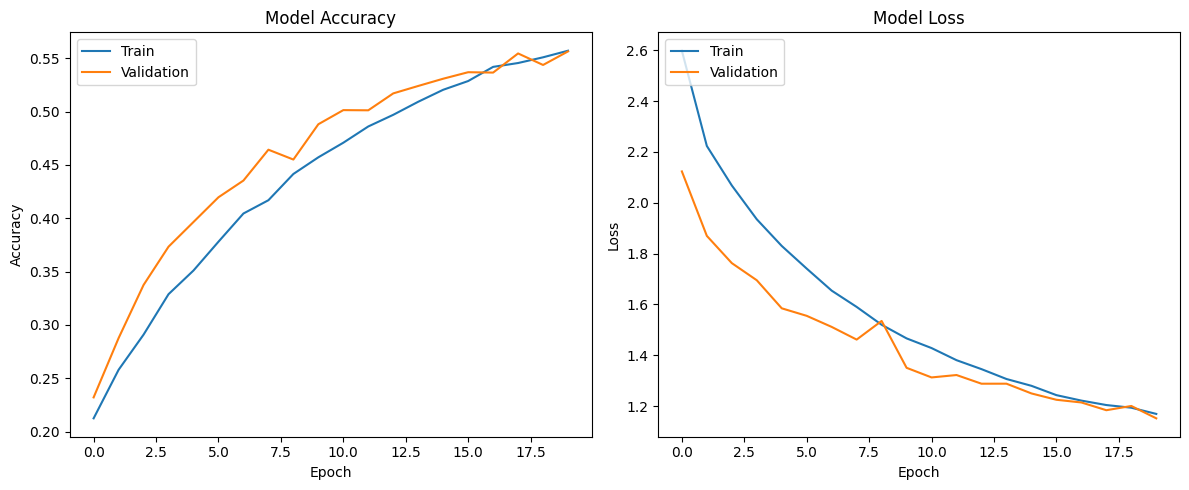

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.58      0.53       958
     disgust       0.65      0.22      0.32       111
        fear       0.43      0.28      0.34      1024
       happy       0.78      0.86      0.82      1774
     neutral       0.54      0.60      0.57      1233
         sad       0.50      0.39      0.44      1247
    surprise       0.66      0.78      0.71       831

    accuracy                           0.60      7178
   macro avg       0.58      0.53      0.53      7178
weighted avg       0.58      0.60      0.58      7178



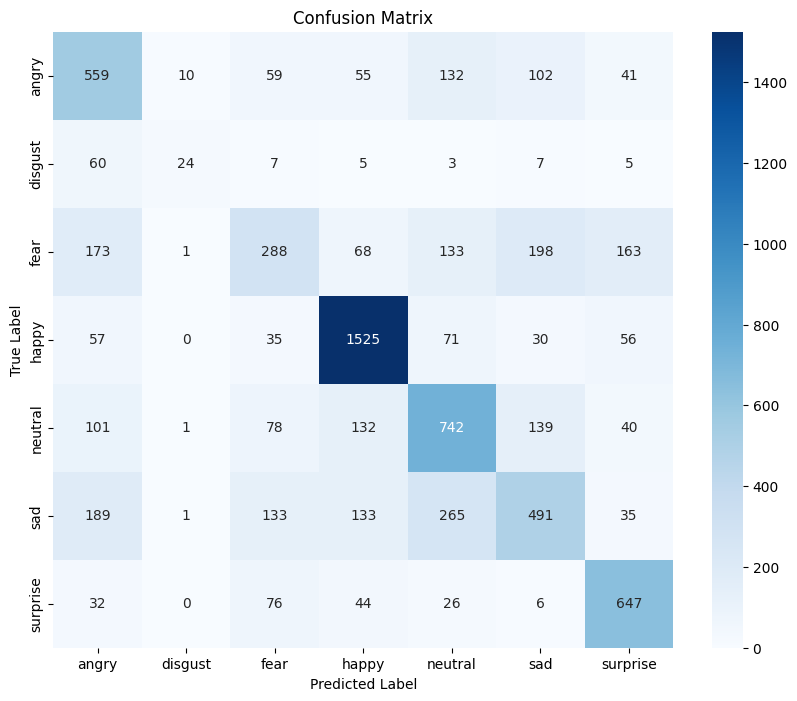

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.5658 - categorical_accuracy: 0.5658 - loss: 1.1410 - precision_3: 0.6862 - recall_3: 0.4221



Test Accuracy: 0.5957
Test Precision: 0.7226
Test Recall: 0.4606


In [32]:
if __name__ == "__main__":
    main()

#### Future Work
- Expand to multi-class emotion classification
- Integrate transfer learning techniques
- Develop a more comprehensive emotion recognition system

#### Conclusion
This emotion classification project demonstrates the potential of deep learning in understanding human emotional states through computer vision techniques. By continuously improving the model and methodology, we can develop more accurate and nuanced emotion recognition systems.

##### Note
Increasing the epoch will improve the accuracy of the model. The model is trained on the FER-2013 dataset, which contains images of faces with various emotions. The model architecture is a convolutional neural network (CNN) designed to classify these emotions. The code includes data preparation, model building, training, evaluation, and prediction functions.